# Extracción de datos

In [ ]:
# Importamos las librerias necesarias ------------------------------------------

from scrapy.item import Item
from scrapy.item import Field
from scrapy.spiders import CrawlSpider
from scrapy.spiders import Rule
from scrapy.linkextractors import LinkExtractor
from scrapy.selector import Selector
from scrapy.loader import ItemLoader
from scrapy.crawler import CrawlerProcess

In [ ]:
# Creamos una clase CrawlSpider para la extracción de los datos ----------------

class Coche(Item):
  marca_modelo = Field()
  descripcion = Field()
  millas = Field()
  antiguedad = Field()
  caja_cambios = Field()
  motor = Field()
  precio_libra = Field()

class CochesCrawler(CrawlSpider):
    name = 'Coches'
    custom_settings = {
        'USER_AGENT': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.169 Safari/537.36',

    }

    download_delay = 2

    allowed_domains = ['cazoo.co.uk']

    start_urls = ['https://www.cazoo.co.uk/cars/bmw/']

    rules = (
        Rule(
            LinkExtractor(
                allow= r'/?page='
            ), follow= True, callback='parse_items'
        ),
    )

    def parse_items(self, response):
      sel = Selector(response)
      modelos = sel.xpath('//div[@class="vehicle-cardstyles__Card-sc-1bxv5iu-0 giiAxy"]')

      for modelo in modelos:
        item = ItemLoader(Coche(), modelo)
        item.add_xpath('marca_modelo', './/p[@data-test-id="card-title"]/text()')
        item.add_xpath('descripcion', './/p[@class="vehicle-cardstyles__DisplayVariant-sc-1bxv5iu-7 cErJHu"]/text()')
        item.add_xpath('millas', './/ul[@data-test-id="tags"]//li[1]/text()')
        item.add_xpath('antiguedad', './/ul[@data-test-id="tags"]//li[2]/text()')
        item.add_xpath('caja_cambios', './/ul[@data-test-id="tags"]//li[3]/text()')
        item.add_xpath('motor', './/ul[@data-test-id="tags"]//li[4]/text()')
        item.add_xpath('precio_libra', './/p[@data-test-id="card-pricing-full-price-gb"]/text()')

        yield item.load_item()

process = CrawlerProcess({
    'FEEDS' : {'coches.csv' : {'format' : 'csv'}}
})

process.crawl(CochesCrawler)
process.start()

# Análisis de los modelos empleados

In [ ]:
# Importamos todas las librerias -----------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from lightgbm.sklearn import LGBMModel
from math import sqrt
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import os

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Diseño de gráficos -----------------------------------------------------------

graph_color = '#5CAEF7'
parameters = {'axes.labelsize': 12,
          'axes.titlesize': 12,
          'xtick.labelsize': 11,
          'ytick.labelsize': 11,}
plt.rcParams.update(parameters)

In [ ]:
# Función para generar gráficas de resultados y análisis de residuos -----------

def graph_res(y_test, pred, residuos_train):
  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

  axes[0, 0].scatter(y_test, pred, edgecolors=graph_color, alpha = 0.4)
  axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
                'k--', color = 'black', lw=2)
  axes[0, 0].set_title('Valor predicho vs valor real', fontsize = 10, fontweight = "bold")
  axes[0, 0].set_xlabel('Real')
  axes[0, 0].set_ylabel('Predicción')
  #axes[0, 0].tick_params(labelsize = 7)

  axes[0, 1].scatter(list(range(len(y_test))), residuos_train,
                   edgecolors=graph_color, alpha = 0.4)
  axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
  axes[0, 1].set_title('Residuos del modelo', fontsize = 10, fontweight = "bold")
  axes[0, 1].set_xlabel('id')
  axes[0, 1].set_ylabel('Residuo')
  #axes[0, 1].tick_params(labelsize = 7)

  sns.histplot(
      data    = residuos_train,
      stat    = "density",
      kde     = True,
      line_kws= {'linewidth': 3, 'color': 'blue', 'lw':5, 'ls': ':'},
      color   = graph_color,
      alpha   = 0.4,
      ax      = axes[1, 0]
  )

  axes[1, 0].set_title('Distribución residuos del modelo', fontsize = 10,
                     fontweight = "bold")
  axes[1, 0].set_xlabel("Residuo")
  #axes[1, 0].tick_params(labelsize = 7)


  sm.qqplot(
      residuos_train,
      fit   = True,
      line  = 'q',
      ax    = axes[1, 1], 
      markerfacecolor = graph_color,
      markeredgecolor = graph_color,
      alpha = 0.7,
      lw    = 2
  )
  axes[1, 1].set_title('Q-Q residuos del modelo', fontsize = 10, fontweight = "bold")
  #axes[1, 1].tick_params(labelsize = 7)


  fig.tight_layout()
  plt.subplots_adjust(top=0.9)
  fig.suptitle('Diagnóstico residuos', fontsize = 12, fontweight = "bold");

In [ ]:
# Cargamos los datos de partida ------------------------------------------------

raw_data = pd.read_csv('/content/coches.csv', sep=',')

In [ ]:
raw_data

,antiguedad,caja_cambios,descripcion,marca_modelo,millas,motor,precio_libra
0,2015 reg,Manual,3L M135i,"BMW, ,1 Series","67,907 miles",Petrol,"£15,250"
1,2019 reg,Manual,1.5L Sport 118i,"BMW, ,1 Series","30,240 miles",Petrol,"£15,300"
2,2018 reg,Manual,1.5L M Sport 216d,"BMW, ,2 Series Active Tourer","35,470 miles",Diesel,"£15,300"
3,2019 reg,Manual,1.5L SE 218i,"BMW, ,2 Series Gran Tourer","38,509 miles",Petrol,"£15,450"
4,2017 reg,Manual,2L Sport 120i,"BMW, ,1 Series","18,568 miles",Petrol,"£15,450"
...,...,...,...,...,...,...,...
542,2017 reg,Automatic,2L M Sport 420d,"BMW, ,4 Series","24,225 miles",Diesel,"£23,250"
543,2017 reg,Automatic,2L SE 530i,"BMW, ,5 Series","22,702 miles",Petrol,"£23,250"
544,2018 reg,Automatic,3L Shadow Edition M140i,"BMW, ,1 Series","29,000 miles",Petrol,"£23,250"
545,2016 reg,Automatic,3L M Sport 335d,"BMW, ,3 Series","46,850 miles",Diesel,"£23,250"


In [ ]:
# Eliminamos los valores nulos

data = raw_data.dropna()

In [ ]:
# Actualizamos la columna antigüedad para calcular los años del coche ----------

data['años'] = data['antiguedad'].apply(lambda x: 2022 - int(x[0:4]))

data

,antiguedad,caja_cambios,descripcion,marca_modelo,millas,motor,precio_libra,años
0,2015 reg,Manual,3L M135i,"BMW, ,1 Series","67,907 miles",Petrol,"£15,250",7
1,2019 reg,Manual,1.5L Sport 118i,"BMW, ,1 Series","30,240 miles",Petrol,"£15,300",3
2,2018 reg,Manual,1.5L M Sport 216d,"BMW, ,2 Series Active Tourer","35,470 miles",Diesel,"£15,300",4
3,2019 reg,Manual,1.5L SE 218i,"BMW, ,2 Series Gran Tourer","38,509 miles",Petrol,"£15,450",3
4,2017 reg,Manual,2L Sport 120i,"BMW, ,1 Series","18,568 miles",Petrol,"£15,450",5
...,...,...,...,...,...,...,...,...
542,2017 reg,Automatic,2L M Sport 420d,"BMW, ,4 Series","24,225 miles",Diesel,"£23,250",5
543,2017 reg,Automatic,2L SE 530i,"BMW, ,5 Series","22,702 miles",Petrol,"£23,250",5
544,2018 reg,Automatic,3L Shadow Edition M140i,"BMW, ,1 Series","29,000 miles",Petrol,"£23,250",4
545,2016 reg,Automatic,3L M Sport 335d,"BMW, ,3 Series","46,850 miles",Diesel,"£23,250",6


In [ ]:
# Añadimos las columnas tipo_motor y acabado extrayendo los datos de la columna descripción 

data['tipo_motor'] = data['descripcion'].str.split(expand = True)[0]
data['acabado'] = data['descripcion'].str.split(expand = True)[1]
data

,antiguedad,caja_cambios,descripcion,marca_modelo,millas,motor,precio_libra,años,tipo_motor,acabado
0,2015 reg,Manual,3L M135i,"BMW, ,1 Series","67,907 miles",Petrol,"£15,250",7,3L,M135i
1,2019 reg,Manual,1.5L Sport 118i,"BMW, ,1 Series","30,240 miles",Petrol,"£15,300",3,1.5L,Sport
2,2018 reg,Manual,1.5L M Sport 216d,"BMW, ,2 Series Active Tourer","35,470 miles",Diesel,"£15,300",4,1.5L,M
3,2019 reg,Manual,1.5L SE 218i,"BMW, ,2 Series Gran Tourer","38,509 miles",Petrol,"£15,450",3,1.5L,SE
4,2017 reg,Manual,2L Sport 120i,"BMW, ,1 Series","18,568 miles",Petrol,"£15,450",5,2L,Sport
...,...,...,...,...,...,...,...,...,...,...
542,2017 reg,Automatic,2L M Sport 420d,"BMW, ,4 Series","24,225 miles",Diesel,"£23,250",5,2L,M
543,2017 reg,Automatic,2L SE 530i,"BMW, ,5 Series","22,702 miles",Petrol,"£23,250",5,2L,SE
544,2018 reg,Automatic,3L Shadow Edition M140i,"BMW, ,1 Series","29,000 miles",Petrol,"£23,250",4,3L,Shadow
545,2016 reg,Automatic,3L M Sport 335d,"BMW, ,3 Series","46,850 miles",Diesel,"£23,250",6,3L,M


In [ ]:
# Cambiamos de millas a kilómetros en la columna kilometros --------------------

data['kms'] = data['millas'].str.split(pat=' miles', expand=True)[0]
data['kms'] = data['kms'].apply(lambda x : round(int(x.replace(',','')) * 1.60934, 2))
data

,antiguedad,caja_cambios,descripcion,marca_modelo,millas,motor,precio_libra,años,tipo_motor,acabado,kms
0,2015 reg,Manual,3L M135i,"BMW, ,1 Series","67,907 miles",Petrol,"£15,250",7,3L,M135i,109285.45
1,2019 reg,Manual,1.5L Sport 118i,"BMW, ,1 Series","30,240 miles",Petrol,"£15,300",3,1.5L,Sport,48666.44
2,2018 reg,Manual,1.5L M Sport 216d,"BMW, ,2 Series Active Tourer","35,470 miles",Diesel,"£15,300",4,1.5L,M,57083.29
3,2019 reg,Manual,1.5L SE 218i,"BMW, ,2 Series Gran Tourer","38,509 miles",Petrol,"£15,450",3,1.5L,SE,61974.07
4,2017 reg,Manual,2L Sport 120i,"BMW, ,1 Series","18,568 miles",Petrol,"£15,450",5,2L,Sport,29882.23
...,...,...,...,...,...,...,...,...,...,...,...
542,2017 reg,Automatic,2L M Sport 420d,"BMW, ,4 Series","24,225 miles",Diesel,"£23,250",5,2L,M,38986.26
543,2017 reg,Automatic,2L SE 530i,"BMW, ,5 Series","22,702 miles",Petrol,"£23,250",5,2L,SE,36535.24
544,2018 reg,Automatic,3L Shadow Edition M140i,"BMW, ,1 Series","29,000 miles",Petrol,"£23,250",4,3L,Shadow,46670.86
545,2016 reg,Automatic,3L M Sport 335d,"BMW, ,3 Series","46,850 miles",Diesel,"£23,250",6,3L,M,75397.58


In [ ]:
# Extraemos la marca de la columna modelo --------------------------------------

data['marca'] = data['marca_modelo'].str.split(pat=',', expand=True)[0]
data['modelo'] = data['marca_modelo'].str.split(pat=',', expand=True)[2]
data

,antiguedad,caja_cambios,descripcion,marca_modelo,millas,motor,precio_libra,años,tipo_motor,acabado,kms,marca,modelo
0,2015 reg,Manual,3L M135i,"BMW, ,1 Series","67,907 miles",Petrol,"£15,250",7,3L,M135i,109285.45,BMW,1 Series
1,2019 reg,Manual,1.5L Sport 118i,"BMW, ,1 Series","30,240 miles",Petrol,"£15,300",3,1.5L,Sport,48666.44,BMW,1 Series
2,2018 reg,Manual,1.5L M Sport 216d,"BMW, ,2 Series Active Tourer","35,470 miles",Diesel,"£15,300",4,1.5L,M,57083.29,BMW,2 Series Active Tourer
3,2019 reg,Manual,1.5L SE 218i,"BMW, ,2 Series Gran Tourer","38,509 miles",Petrol,"£15,450",3,1.5L,SE,61974.07,BMW,2 Series Gran Tourer
4,2017 reg,Manual,2L Sport 120i,"BMW, ,1 Series","18,568 miles",Petrol,"£15,450",5,2L,Sport,29882.23,BMW,1 Series
...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,2017 reg,Automatic,2L M Sport 420d,"BMW, ,4 Series","24,225 miles",Diesel,"£23,250",5,2L,M,38986.26,BMW,4 Series
543,2017 reg,Automatic,2L SE 530i,"BMW, ,5 Series","22,702 miles",Petrol,"£23,250",5,2L,SE,36535.24,BMW,5 Series
544,2018 reg,Automatic,3L Shadow Edition M140i,"BMW, ,1 Series","29,000 miles",Petrol,"£23,250",4,3L,Shadow,46670.86,BMW,1 Series
545,2016 reg,Automatic,3L M Sport 335d,"BMW, ,3 Series","46,850 miles",Diesel,"£23,250",6,3L,M,75397.58,BMW,3 Series


In [ ]:
# Convertimos la columna precio de libras a euros ------------------------------

data['precio_euro'] = data['precio_libra'].apply(lambda x: int(x[1:].replace(',','')) * 1.18)
data

,antiguedad,caja_cambios,descripcion,marca_modelo,millas,motor,precio_libra,años,tipo_motor,acabado,kms,marca,modelo,precio_euro
0,2015 reg,Manual,3L M135i,"BMW, ,1 Series","67,907 miles",Petrol,"£15,250",7,3L,M135i,109285.45,BMW,1 Series,17995.0
1,2019 reg,Manual,1.5L Sport 118i,"BMW, ,1 Series","30,240 miles",Petrol,"£15,300",3,1.5L,Sport,48666.44,BMW,1 Series,18054.0
2,2018 reg,Manual,1.5L M Sport 216d,"BMW, ,2 Series Active Tourer","35,470 miles",Diesel,"£15,300",4,1.5L,M,57083.29,BMW,2 Series Active Tourer,18054.0
3,2019 reg,Manual,1.5L SE 218i,"BMW, ,2 Series Gran Tourer","38,509 miles",Petrol,"£15,450",3,1.5L,SE,61974.07,BMW,2 Series Gran Tourer,18231.0
4,2017 reg,Manual,2L Sport 120i,"BMW, ,1 Series","18,568 miles",Petrol,"£15,450",5,2L,Sport,29882.23,BMW,1 Series,18231.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,2017 reg,Automatic,2L M Sport 420d,"BMW, ,4 Series","24,225 miles",Diesel,"£23,250",5,2L,M,38986.26,BMW,4 Series,27435.0
543,2017 reg,Automatic,2L SE 530i,"BMW, ,5 Series","22,702 miles",Petrol,"£23,250",5,2L,SE,36535.24,BMW,5 Series,27435.0
544,2018 reg,Automatic,3L Shadow Edition M140i,"BMW, ,1 Series","29,000 miles",Petrol,"£23,250",4,3L,Shadow,46670.86,BMW,1 Series,27435.0
545,2016 reg,Automatic,3L M Sport 335d,"BMW, ,3 Series","46,850 miles",Diesel,"£23,250",6,3L,M,75397.58,BMW,3 Series,27435.0


In [ ]:
# Nos quedamos con las columnas necesarias -------------------------------------

df = data[['marca', 'modelo', 'tipo_motor', 'acabado', 'motor', 'caja_cambios', 'kms', 'años', 'precio_euro']]
df

,marca,modelo,tipo_motor,acabado,motor,caja_cambios,kms,años,precio_euro
0,BMW,1 Series,3L,M135i,Petrol,Manual,109285.45,7,17995.0
1,BMW,1 Series,1.5L,Sport,Petrol,Manual,48666.44,3,18054.0
2,BMW,2 Series Active Tourer,1.5L,M,Diesel,Manual,57083.29,4,18054.0
3,BMW,2 Series Gran Tourer,1.5L,SE,Petrol,Manual,61974.07,3,18231.0
4,BMW,1 Series,2L,Sport,Petrol,Manual,29882.23,5,18231.0
...,...,...,...,...,...,...,...,...,...
542,BMW,4 Series,2L,M,Diesel,Automatic,38986.26,5,27435.0
543,BMW,5 Series,2L,SE,Petrol,Automatic,36535.24,5,27435.0
544,BMW,1 Series,3L,Shadow,Petrol,Automatic,46670.86,4,27435.0
545,BMW,3 Series,3L,M,Diesel,Automatic,75397.58,6,27435.0


# EDA

## Análisis de variables categóricas

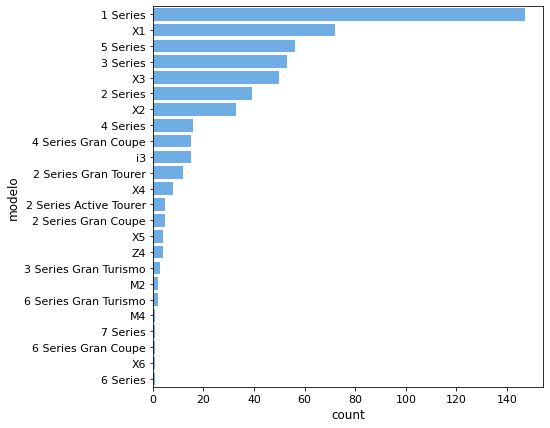

In [ ]:
fig = plt.figure(figsize=(7,7))
sns.countplot(y='modelo', data=df, order=df['modelo'].value_counts().index, color=graph_color)
plt.show()

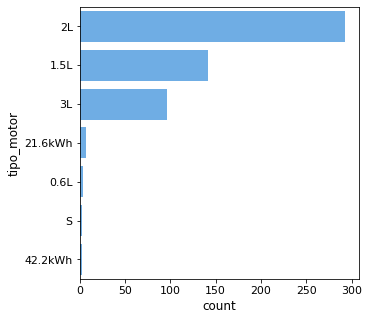

In [ ]:
fig = plt.figure(figsize=(5,5))
sns.countplot(y='tipo_motor', data=df, order=df['tipo_motor'].value_counts().index, color= graph_color)
plt.show()

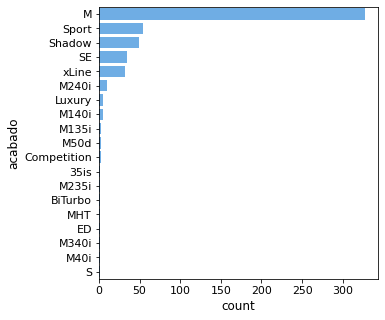

In [ ]:
fig = plt.figure(figsize=(5,5))
sns.countplot(y='acabado', data=df, order=df['acabado'].value_counts().index, color=graph_color)
plt.show()

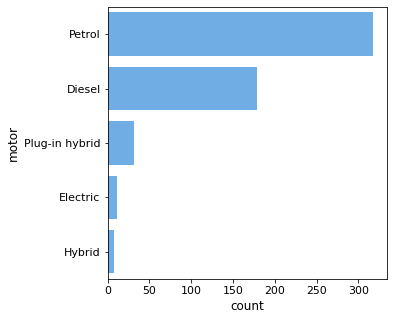

In [ ]:
fig = plt.figure(figsize=(5,5))
sns.countplot(y='motor', data=df, order=df['motor'].value_counts().index, color=graph_color)
plt.show()

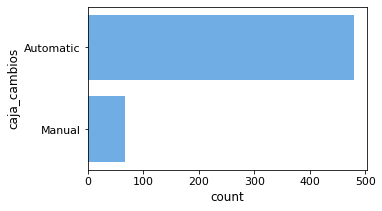

In [ ]:
fig = plt.figure(figsize=(5,3))
sns.countplot(y='caja_cambios', data=df, order=df['caja_cambios'].value_counts().index, color=graph_color)
plt.show()

## Análisis de variables numéricas

In [ ]:
# Análisis de variables numéricas ----------------------------------------------

df.describe()

,kms,años,precio_euro
count,546.00000,546.000000,546.000000
mean,45678.51044,3.520147,28083.675824
std,24897.27980,1.381582,6524.100388
min,785.36000,0.000000,17995.000000
25%,28033.89750,3.000000,23570.500000
50%,42390.01500,3.000000,27199.000000
75%,60295.53500,4.000000,31314.250000
max,182594.11000,7.000000,50976.000000


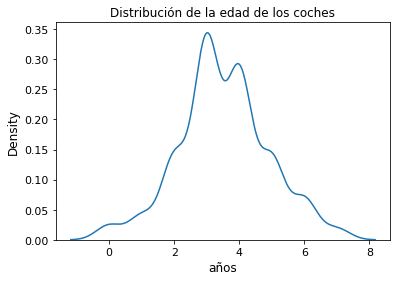

In [ ]:
sns.distplot(df['años'], hist=False)
plt.title('Distribución de la edad de los coches')
plt.show()

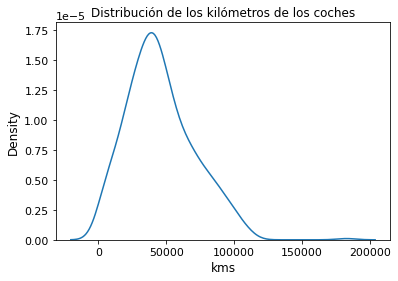

In [ ]:
sns.distplot(df['kms'], hist=False)
plt.title('Distribución de los kilómetros de los coches')
plt.show()

## Visualización de datos categóricos

In [ ]:
df.columns

Index(['marca', 'modelo', 'tipo_motor', 'acabado', 'motor', 'caja_cambios',
       'kms', 'años', 'precio_euro'],
      dtype='object')

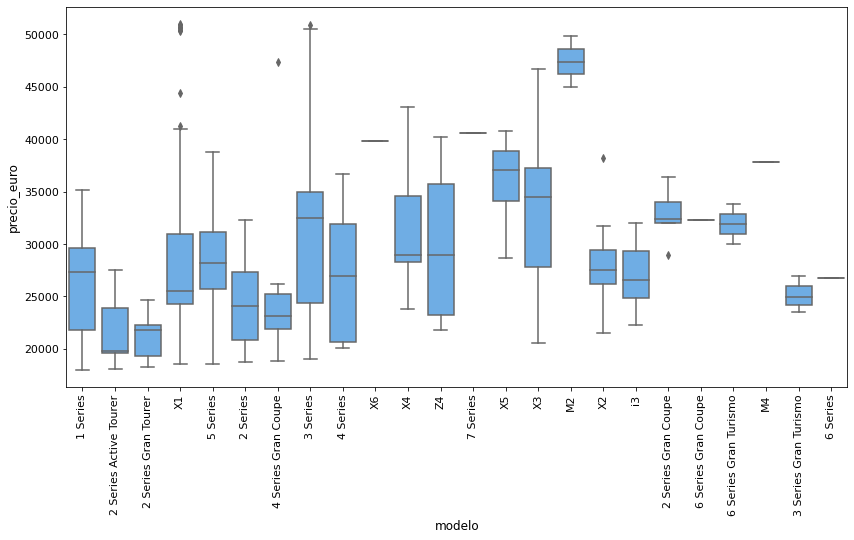

In [ ]:
fig = plt.figure(figsize=(14,7))
sns.boxplot(data=df, x='modelo', y='precio_euro', color=graph_color)
plt.xticks(rotation=90)
plt.show()

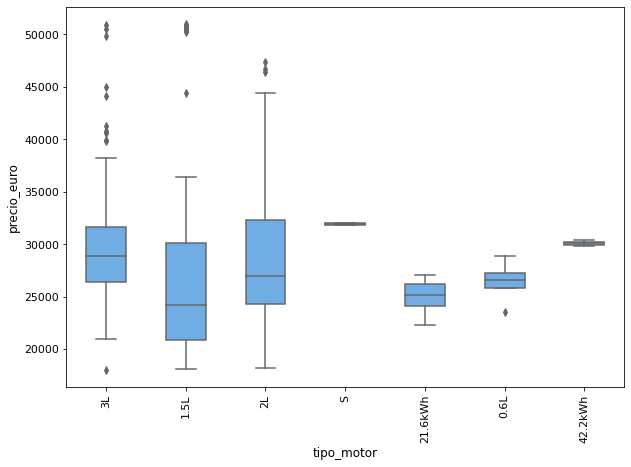

In [ ]:
fig = plt.figure(figsize=(10,7))
sns.boxplot(data=df, x='tipo_motor', y='precio_euro', color=graph_color, width=0.5)
plt.xticks(rotation=90)
plt.show()

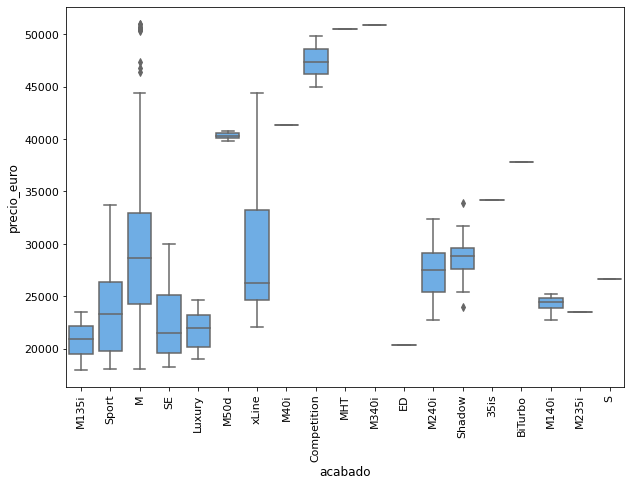

In [ ]:
fig = plt.figure(figsize=(10,7))
sns.boxplot(data=df, x='acabado', y='precio_euro', color=graph_color)
plt.xticks(rotation=90)
plt.show()

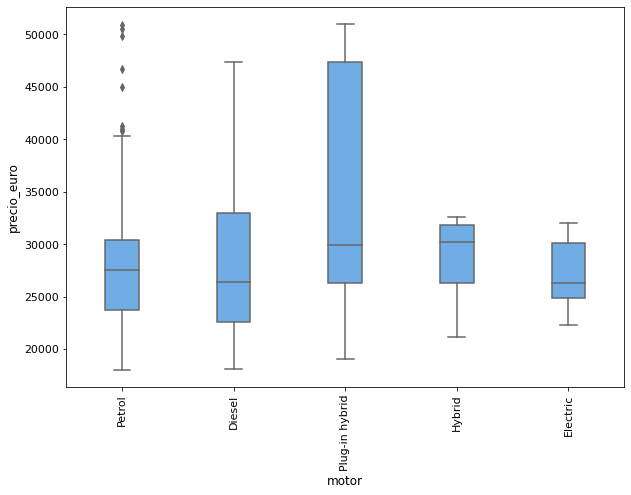

In [ ]:
fig = plt.figure(figsize=(10,7))
sns.boxplot(data=df, x='motor', y='precio_euro', color=graph_color, width=0.3)
plt.xticks(rotation=90)
plt.show()

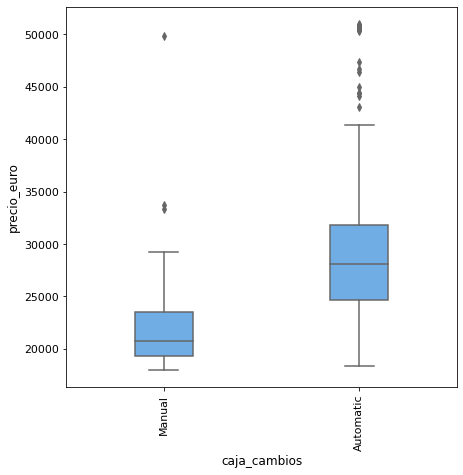

In [ ]:
fig = plt.figure(figsize=(7,7))
sns.boxplot(data=df, x='caja_cambios', y='precio_euro', color=graph_color, width=0.3)
plt.xticks(rotation=90)
plt.show()

## Visualización de datos numéricos

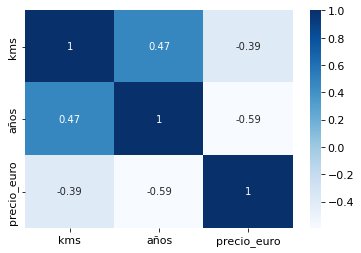

In [ ]:
sns.heatmap(df.corr(), annot=True, cmap='Blues')

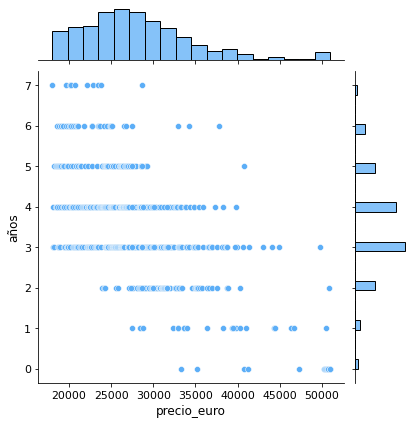

In [ ]:
sns.jointplot(data=df, x='precio_euro', y='años', alpha=1, color=graph_color)

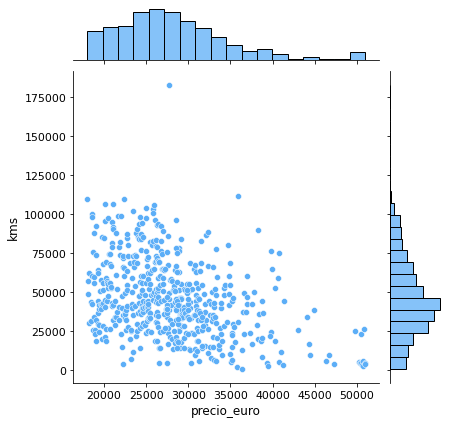

In [ ]:
sns.jointplot(data=df, x='precio_euro', y='kms', alpha=1, color=graph_color)

# Preprocesado de datos

In [ ]:
df.columns

Index(['marca', 'modelo', 'tipo_motor', 'acabado', 'motor', 'caja_cambios',
       'kms', 'años', 'precio_euro'],
      dtype='object')

In [ ]:
# Extraemos las variables categóricas y numéricas ------------------------------

num_features = df[['kms', 'años']]
cat_features = df[['modelo', 'tipo_motor', 'acabado', 'motor', 'caja_cambios']]

In [ ]:
# Codificamos las variables categóricas ----------------------------------------

for i in cat_features:
  le = LabelEncoder()
  cat_features[i] = le.fit_transform(cat_features[i])

In [ ]:
# Codificamos las variables numéricas ------------------------------------------

scaler = StandardScaler()
scaler.fit(num_features)
num_scaled = scaler.transform(num_features)
num_scaled = pd.DataFrame(num_scaled, index=num_features.index, columns=num_features.columns)

In [ ]:
# Concatenamos los dataframes con las variables categóricas y numéricas --------
# Extraemos la variable objetivo -----------------------------------------------

X = pd.concat([num_scaled, cat_features], axis=1)
y = df['precio_euro']

In [ ]:
# Comprobamos que no existan valores nulos -------------------------------------

X.isna().sum()

kms             0
años            0
modelo          0
tipo_motor      0
acabado         0
motor           0
caja_cambios    0
dtype: int64

# Modelos

### Random Forest

In [ ]:
# Dividimos el conjunto de datos en entrenamiento y test -----------------------

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=34)

In [ ]:
# Aplicamos un modelo Random Forest Reresor ---------------------------------------------

model_rf = RandomForestRegressor()

In [ ]:
# Buscamos los mejores parámetros para el modelo -------------------------------

parameters_rf = {
    'max_depth':[5,10,15],
    'max_features':['auto','sqrt'],
    'n_estimators': [500,1000,1500]
}

RF_model = GridSearchCV(model_rf, parameters_rf, cv=10, n_jobs=4)
RF_model.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=4,
             param_grid={'max_depth': [5, 10, 15],
                         'max_features': ['auto', 'sqrt'],
                         'n_estimators': [500, 1000, 1500]})

In [ ]:
# Mejores parámetros del modelo ------------------------------------------------

RF_model.best_params_

{'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 1000}

In [ ]:
# Evaluamos el modelo ----------------------------------------------------------

pred_rf = RF_model.predict(X_test)

print("\t\tError Table")
print('Mean Absolute Error      : ', mean_absolute_error(y_test, pred_rf))
print('Mean Squared  Error      : ', mean_squared_error(y_test, pred_rf))
print('Root Mean Squared  Error : ', np.sqrt(mean_squared_error(y_test, pred_rf)))
print('R Squared Error          : ', r2_score(y_test, pred_rf))

		Error Table
Mean Absolute Error      :  1524.0494608684962
Mean Squared  Error      :  4438429.415185426
Root Mean Squared  Error :  2106.758034323217
R Squared Error          :  0.9171395113475104


In [ ]:
# Cálculo de residuos ----------------------------------------------------------

residuos_train_rf = pred_rf - y_test

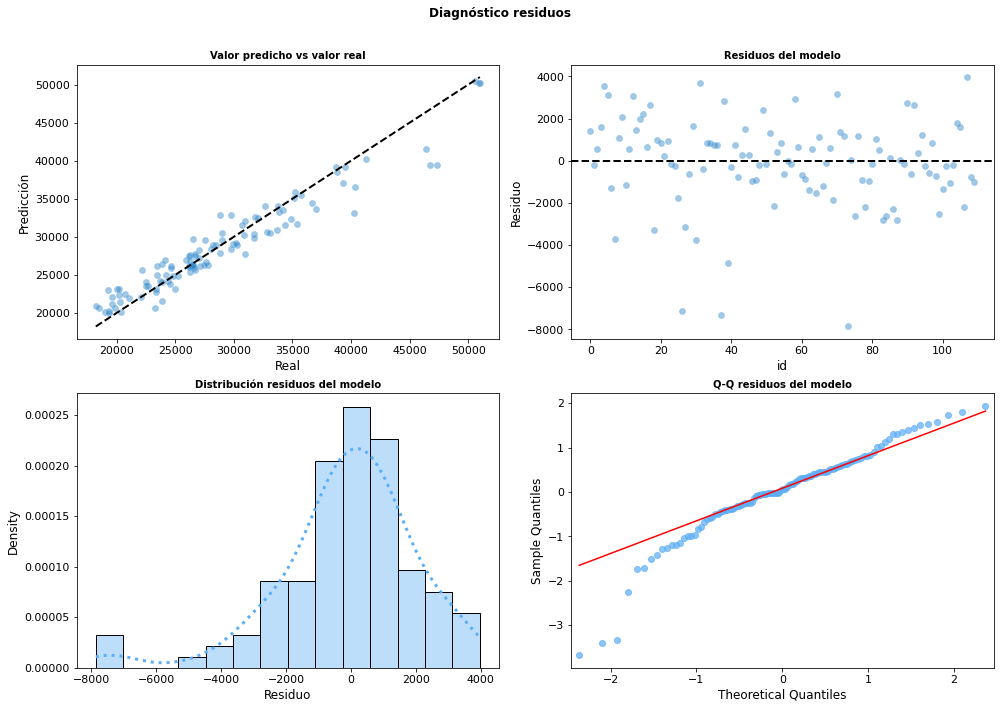

In [ ]:
# Generación de gráficos de predicciones y análisis de residuos ----------------

graph_res(y_test, pred_rf, residuos_train_rf)

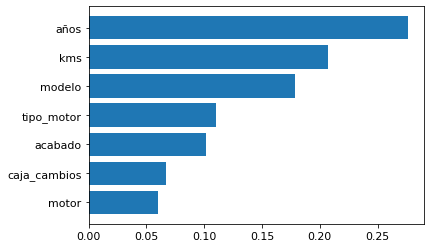

In [ ]:
# Análisis de las características principales ----------------------------------

features = X.columns
importances = RF_model.best_estimator_.feature_importances_
indices = np.argsort(importances)

plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.show()

### LGBM

In [ ]:
# Aplicamos un modelo LGBMRegresor ---------------------------------------------

model_lgbm = lgb.LGBMRegressor()

In [ ]:
# Buscamos los mejores parámetros para el modelo -------------------------------

parameters = {
    'max_deph':[32,64],
    'min_data_in_leaf':[1,5,10],
    'colsample_bytree':[0.8,1],
    'n_estimators':[50, 100]
}
n_cpu = os.cpu_count()
n_thread = n_cpu*2

LGBM_model = GridSearchCV(model_lgbm, parameters, cv=10, n_jobs=4)
LGBM_model.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LGBMRegressor(), n_jobs=4,
             param_grid={'colsample_bytree': [0.8, 1], 'max_deph': [32, 64],
                         'min_data_in_leaf': [1, 5, 10],
                         'n_estimators': [50, 100]})

In [ ]:
# Mejores parámetros del modelo ------------------------------------------------

LGBM_model.best_params_

{'colsample_bytree': 0.8,
 'max_deph': 32,
 'min_data_in_leaf': 5,
 'n_estimators': 100}

In [ ]:
# Evaluamos el modelo ----------------------------------------------------------

pred_lgbm = LGBM_model.predict(X_test)

print("\t\tError Table")
print('Mean Absolute Error      : ', mean_absolute_error(y_test, pred_lgbm))
print('Mean Squared  Error      : ', mean_squared_error(y_test, pred_lgbm))
print('Root Mean Squared  Error : ', np.sqrt(mean_squared_error(y_test, pred_lgbm)))
print('R Squared Error          : ', r2_score(y_test, pred_lgbm))


		Error Table
Mean Absolute Error      :  1473.4882196585286
Mean Squared  Error      :  3815142.905924012
Root Mean Squared  Error :  1953.2390805848659
R Squared Error          :  0.9287755699386883


In [ ]:
# Cálculo de residuos ----------------------------------------------------------

residuos_train_lgbm = pred_lgbm - y_test

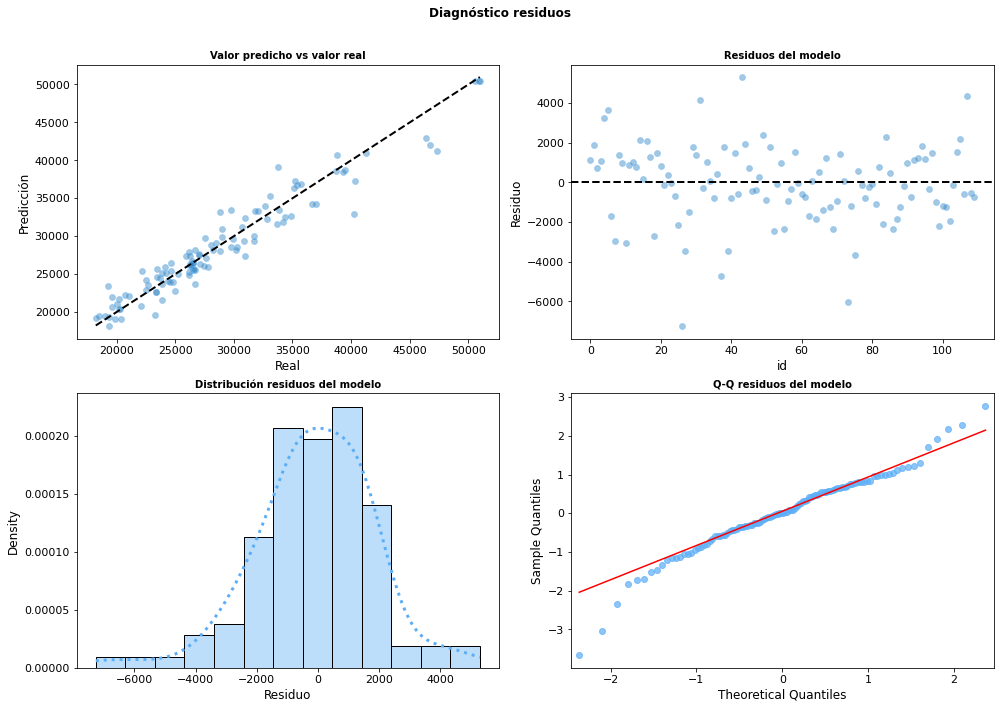

In [ ]:
# Generación de gráficos -------------------------------------------------------

graph_res(y_test, pred_lgbm, residuos_train_lgbm)

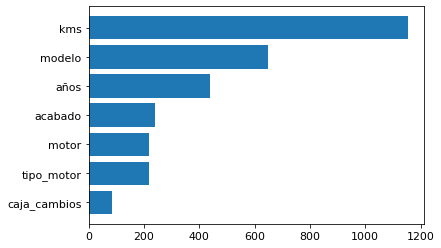

In [ ]:
# Análisis de las características principales ----------------------------------

features = X.columns
importances = LGBM_model.best_estimator_.feature_importances_
indices = np.argsort(importances)

plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.show()

# Análisis de los modelos

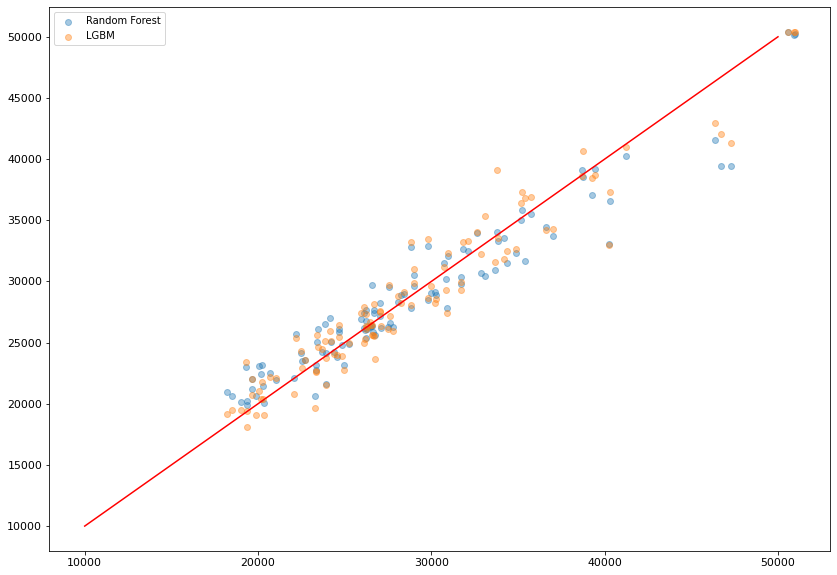

In [ ]:
# Distribución de las predicciones ---------------------------------------------

plt.figure(figsize=(14,10))
plt.scatter(x=y_test, y=pred_rf,  alpha = 0.4)
plt.scatter(x=y_test, y=pred_lgbm,  alpha = 0.4)
plt.legend(['Random Forest', 'LGBM'])
plt.plot([10000, 50000], [10000,50000], 'r-')

Text(0, 0.5, 'Residuo')

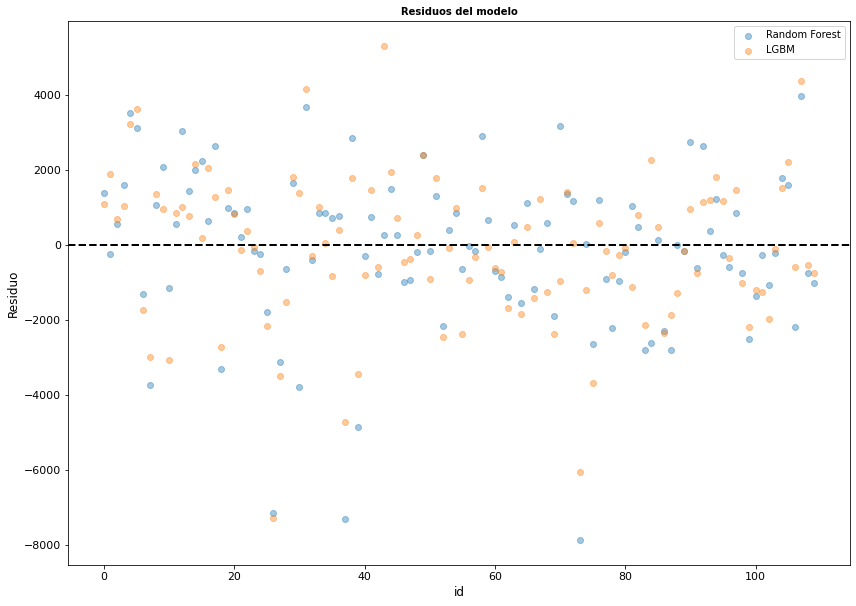

In [ ]:
# Análisis de los residuos -----------------------------------------------------

plt.figure(figsize=(14,10))
plt.scatter(list(range(len(y_test))), residuos_train_rf, alpha = 0.4)
plt.scatter(list(range(len(y_test))), residuos_train_lgbm, alpha = 0.4)
plt.legend(['Random Forest', 'LGBM'])
plt.axhline(y = 0, linestyle = '--', color = 'black', lw=2)
plt.title('Residuos del modelo', fontsize = 10, fontweight = "bold")
plt.xlabel('id')
plt.ylabel('Residuo')

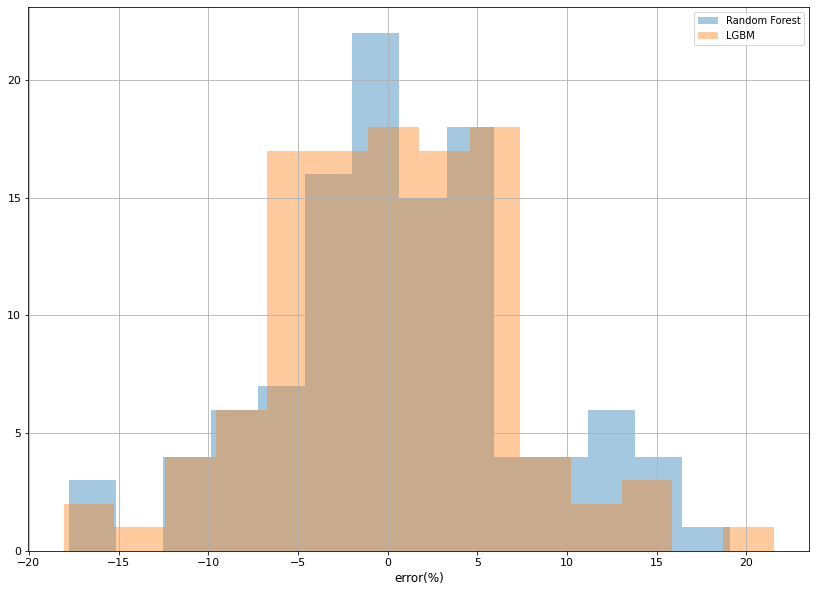

In [ ]:
# Distribución de los errores de las predicciones ------------------------------

err_rf = (pred_rf-y_test)/y_test*100
err_lgbm = (pred_lgbm-y_test)/y_test*100

plt.figure(figsize=(14,10))
plt.hist(err_rf, bins=14, alpha=0.4)
plt.hist(err_lgbm, bins=14, alpha=0.4)
plt.legend(['Random Forest', 'LGBM'])
plt.xlabel('error(%)')
plt.grid()